In [1]:
from import_images import getImages
from import_model import getModel
from make_predictions import makePredictions
import numpy as np

import torch

from cellpose import resnet_torch
from cellpose import transforms
from cellpose import utils
import cv2

import time

from unet_architecture import UNet
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision
import numpy as np

import matplotlib.pyplot as plt

In [2]:
images_directory = "C:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\pipeline\\uploads\\"
images = getImages(images_directory)

directory = "C:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\datasets\\Fluo-C2DL-Huh7\\01\\models\\CP_20230601_101328"
cellpose_model = getModel(directory)

In [3]:
#get model
directory = "C:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\datasets\\Fluo-C2DL-Huh7\\01\\models\\CP_20230601_101328"
cpnet = resnet_torch.CPnet(nbase=[2,32,64,128,256],nout=3,sz=3)
cpnet.load_model(directory)

#size at which we rescale the image so that the size of the nucleis match the size the cellpose models needs
rescale = cpnet.diam_mean/cpnet.diam_labels


In [66]:
print(cpnet)

CPnet(
  (downsample): downsample(
    (down): Sequential(
      (res_down_0): resdown(
        (conv): Sequential(
          (conv_0): Sequential(
            (0): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU(inplace=True)
            (2): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (conv_1): Sequential(
            (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU(inplace=True)
            (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (conv_2): Sequential(
            (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU(inplace=True)
            (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (conv_3): Sequential(
            (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, tra

In [63]:
def get_pre_activations(image,cpnet):
    rescale = cpnet.diam_mean/cpnet.diam_labels
    shape1, shape2 = image.shape[0], image.shape[1]

    x = transforms.resize_image(image, rsz=rescale,no_channels=True)
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)
    x = np.concatenate((x, x), axis=0)
    x = torch.from_numpy(x)
    x = x.unsqueeze(0)

    y, style = cpnet(x)
    y = y.squeeze(0)
    y = y.cpu().detach().numpy()

    return y

In [64]:
res = get_pre_activations(images[0],cpnet)
print(images[0].shape)
print(res.shape)

(1024, 1024)
(32, 536, 536)


In [65]:
unet = UNet()
pred = unet(torch.from_numpy(images[0]).unsqueeze(0).unsqueeze(0))
print(pred.shape)

torch.Size([1, 32, 512, 512])


In [6]:
training_images = images
training_probability_maps, training_cell_masks = makePredictions(images, cellpose_model)
training_pre_activations = []
for image in training_images:
    training_pre_activations.append(get_pre_activations(image,cpnet))

a
a
a
a
a
a
a
a
a
a
a
torch.Size([1, 32, 536, 536])
torch.Size([1, 32, 536, 536])
torch.Size([1, 32, 536, 536])
torch.Size([1, 32, 536, 536])
torch.Size([1, 32, 536, 536])
torch.Size([1, 32, 536, 536])
torch.Size([1, 32, 536, 536])
torch.Size([1, 32, 536, 536])
torch.Size([1, 32, 536, 536])
torch.Size([1, 32, 536, 536])
torch.Size([1, 32, 536, 536])


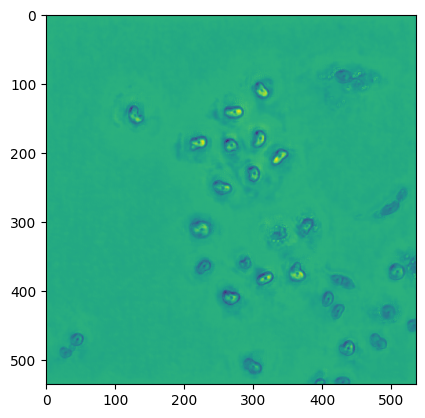

In [56]:
plt.imshow(training_pre_activations[0][4])

In [7]:
print(training_pre_activations[0].shape)

(32, 536, 536)


In [8]:
print(np.unique(training_pre_activations[2]))

print(np.unique(training_pre_activations[2]-np.min(training_pre_activations[2]))/(np.max(training_pre_activations[2])-np.min(training_pre_activations[2])))

[-217.2636   -217.13249  -213.24152  ...   58.211742   58.70198
   58.710857]
[0.000000e+00 4.750567e-04 1.457410e-02 ... 9.981914e-01 9.999678e-01
 1.000000e+00]


In [45]:
class ImageDataset(Dataset):
    def __init__(self, image, cellprob, cellmask):
        self.image = image
        self.cellprob = cellprob
        self.cellmask = cellmask

    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        img = self.image[idx]
        cellprob = self.cellprob[idx]
        cellmask = self.cellmask[idx]
        return img, cellprob, cellmask
    
def split_image_set(set):
    splitted = []
    for image in set:
        for i in range(0, image.shape[0], 134):
            for j in range(0, image.shape[0], 134):
                sub_img = image[i:i+134, j:j+134]
                splitted.append(sub_img)
    return splitted

#normalise the training_images
training_images = [(image-np.min(image))/(np.max(image)-np.min(image)) for image in training_images]
#normalise the probability maps
#pm_normalised = [(image-np.min(image))/(np.max(image)-np.min(image)) for image in training_pre_activations]
#pm_normalised = [(image-np.min(image))/(np.max(image)-np.min(image)) for image in training_pre_activations]

#binarise the cell masks
cm_binary = [np.where(image > 0, 1.0, 0.0) for image in training_cell_masks]

#pad the images, probability maps and cell masks to 1024x1024
#images_pad = [np.pad(img,((0,1024-img.shape[0]),(0,1024-img.shape[1])),mode='constant',constant_values=0) for img in training_images]
#pm_norm_pad = [np.pad(img,((0, 0), (0,1024-img.shape[1]),(0,1024-img.shape[2]) ),mode='constant',constant_values=0) for img in training_pre_activations]
#cm_bin_pad = [np.pad(img,((0,1024-img.shape[0]),(0,1024-img.shape[1])),mode='constant',constant_values=0) for img in cm_binary]

images_pad = []
for image in training_images:
    images_pad.append(cv2.resize(image, dsize=(268, 268), interpolation=cv2.INTER_NEAREST))
cm_bin_pad = []
for image in cm_binary:
    cm_bin_pad.append(cv2.resize(image, dsize=(268, 268), interpolation=cv2.INTER_NEAREST))

#split the images, probability maps and cell masks into 256x256 images
images_pad_split = split_image_set(images_pad)
pm_norm_pad_split = []
for image in training_pre_activations:
    for i in range(0, 268, 134):
        for j in range(0, 268, 134):
            sub_img = image[:, i:i+134, j:j+134]
            pm_norm_pad_split.append(sub_img)
cm_bin_pad_split = split_image_set(cm_bin_pad)

#augment with rotations
images_rotated = []
pm_rotated = []
cm_rotated = []
for i in range(len(images_pad_split)):
    for j in range(1,4):
        images_rotated.append(np.rot90(images_pad_split[i],j))
        pm_rotated.append(np.rot90(pm_norm_pad_split[i], j, axes=(1, 2)))
        cm_rotated.append(np.rot90(cm_bin_pad_split[i],j))

#remove the images from cm_bin_pad_split that only have 0s, and remove them from images_pad_split and pm_norm_pad_split
images_pad_split_filtered = [images_rotated[i] for i in range(len(cm_rotated)) if np.sum(cm_rotated[i]) > 0]
pm_norm_pad_split_filtered = [pm_rotated[i] for i in range(len(cm_rotated)) if np.sum(cm_rotated[i]) > 0]
cm_bin_pad_split_filtered = [img for img in cm_rotated if np.sum(img) > 0]

print(len(images_pad_split_filtered), len(pm_norm_pad_split_filtered), len(cm_bin_pad_split_filtered))

images_torch = [torch.from_numpy(np.array(images_pad_split_filtered[i])) for i in range(len(images_pad_split_filtered))]

pm_torch = []
for i in range(len(pm_norm_pad_split_filtered)):
    pm_torch.append(torch.from_numpy(np.array(pm_norm_pad_split_filtered[i])))

cm_torch = [torch.from_numpy(np.array(cm_bin_pad_split_filtered[i])) for i in range(len(cm_bin_pad_split_filtered))]

132 132 132


In [46]:
print(images_torch[0].shape, pm_torch[0].shape, cm_torch[0].shape)

torch.Size([134, 134]) torch.Size([32, 134, 134]) torch.Size([134, 134])


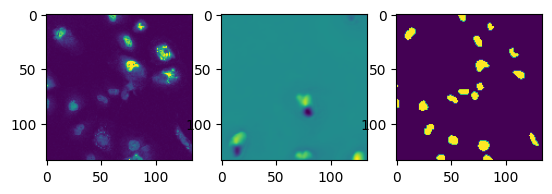

In [50]:

index = np.random.randint(0, len(images_torch))
#index = 0
plt.subplot(1,3,1)
plt.imshow(images_torch[index])
plt.subplot(1,3,2)
plt.imshow(pm_torch[index][2])
plt.subplot(1,3,3)
plt.imshow(cm_torch[index])
plt.show()

In [27]:
unet = UNet(nbClasses=3)
test = unet(torch.rand(1, 1, 268, 268))

print(test.shape)

torch.Size([1, 32, 134, 134])


In [28]:
train_dataset = ImageDataset(images_torch[:1], pm_torch[:1], cm_torch[:1])
print(len(train_dataset))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)


1


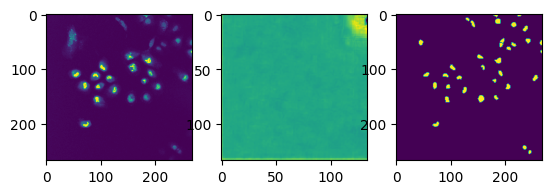

In [31]:
plt.subplot(1,3,1)
plt.imshow(images_torch[0])
plt.subplot(1,3,2)
plt.imshow(pm_torch[0][1])
plt.subplot(1,3,3)
plt.imshow(cm_torch[0])
plt.show()

In [32]:
print(torch.unique(cm_torch[0]))

tensor([0., 1.], dtype=torch.float64)


In [33]:
print(np.unique(pm_torch[0]))

[-23.08442   -21.235485  -20.070892  ...   3.0565667   3.2196999
   3.8341608]


In [40]:

class KDLoss(torch.nn.Module):
    def __init__(self, alpha=1.0, beta = 0.0, temperature=1):
        super(KDLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.temperature = temperature

    def forward(self, y_pred_logits, y_pred_mask, y_cp_true, y_cm_true):
        #print(y_pred_logits.shape, y_pred_mask.shape, y_cp_true.shape, y_cm_true.shape)
        
        #y_pred_sig = torch.sigmoid(y_pred_logits)
        #y_pred_bin = torch.where(y_pred_sig > 0.5, 1.0, 0.0)
        #cast y_pred_bin to float
        #y_pred_bin = y_pred_bin.type(torch.FloatTensor)
        #print(y_pred_logits.shape, y_cp_true.shape)
        y_pred = F.softmax(y_pred_logits, dim=1)
        y_cp_true_softmax = F.softmax(y_cp_true, dim=1)
        #print(y_pred.shape, y_cp_true_softmax.shape)
        kd_loss = F.mse_loss(y_pred, y_cp_true_softmax)

        #ce_loss = F.binary_cross_entropy(y_pred_mask.float(), y_cm_true.float())

        #binarised = torch.where(F.sigmoid(y_pred_logits) > 0.4, 1.0, 0.0)
        #ce_loss = F.binary_cross_entropy(binarised, y_cp_true)  # compute binary cross-entropy loss
        #loss = F.binary_cross_entropy_with_logits(y_pred_logits, y_cm_true)
        #y_pred_mask = torch.sigmoid(y_pred_logits)  # compute predicted probabilities
        #y_pred_mask = torch.where(y_pred_mask>0.4,1.0,0.0) # binarise
          # compute KL divergence loss
        
        loss = self.alpha * kd_loss  # combine losses
        return loss

def denormalize(array, min_value, max_value):
    normalized_range = 1.0
    normalized_array = array
    denormalized_array = (normalized_array * (max_value - min_value)) + min_value
    return denormalized_array

def trainEpoch(unet, train_loader, loss_fn, optimiser, scheduler, epoch_num):
    time_start = time.time()
    
    unet.train()

    train_loss = 0
    for image, cellprob, cellmask in train_loader:
        (image,cellprob,cellmask) = (image.to('cuda:0'),cellprob.to('cuda:0'),cellmask.to('cuda:0')) # sending the data to the device (cpu or GPU)

        image = image.unsqueeze(1)
        pred = unet(image).squeeze(1) #make a prediction
        #print('pred shape', pred.shape)
        

        min_value = -16
        max_value = 34
        #pred = denormalize(pred, min_value, max_value)

        detranspose = (1,2,0)
        predicted_masks = []
        for p in pred:
            p = p.cpu().detach().numpy()
            p = denormalize(p, min_value, max_value)
            p = np.transpose(p, detranspose)
            p = utils.get_masks_unet(p, cell_threshold=2.0, boundary_threshold=0.5)
            p = utils.fill_holes_and_remove_small_masks(p, min_size=15)
            p = torch.from_numpy(p).to('cuda:0')
            predicted_masks.append(p)
        predicted_masks = torch.stack(predicted_masks).unsqueeze(1)
        #cellprob = torch.unsqueeze(cellprob,1)
        cellmask = torch.unsqueeze(cellmask,1)

        #if len(np.unique(predicted_masks.cpu().detach().numpy())) > 1:
        #    plt.subplot(1,2,1)
        #    plt.imshow(predicted_masks[0].cpu().detach().numpy()[0])
        #    plt.subplot(1,2,2)
        #    plt.imshow(cellmask[0].cpu().detach().numpy()[0])
        #    plt.show()

        #loss = loss_fn(pred, cellprob,10) # calculate the loss of that prediction
        
        #print(torch.unique(pred),torch.unique(predicted_masks),torch.unique(cellprob),torch.unique(cellmask))

        if 5 ==4:
            plt.subplot(1,4,1)
            plt.imshow(pred[0].cpu().detach().numpy()[0])
            plt.subplot(1,4,2)
            plt.imshow(predicted_masks[0].cpu().detach().numpy()[0])
            plt.subplot(1,4,3)
            plt.imshow(cellprob[0].cpu().detach().numpy()[0])
            plt.subplot(1,4,4)
            plt.imshow(cellmask[0].cpu().detach().numpy()[0])
            plt.show()

        pred, predicted_masks, cellprob, cellmask = pred.squeeze(0), predicted_masks.float().squeeze(0), cellprob.squeeze(0), cellmask.squeeze(0)


        
        #print(pred.shape,predicted_masks.shape,cellprob.shape,cellmask.shape)
        loss = loss_fn(pred, predicted_masks.float(), cellprob, cellmask) # calculate the loss of that prediction
        #loss = loss_fn(pred, cellmask )
        train_loss += loss
    
        optimiser.zero_grad() # zero out the accumulated gradients
        loss.backward() # backpropagate the loss
        optimiser.step() # update model parameters
        if scheduler is not None:
            scheduler.step()
    train_loss = train_loss.item()/len(train_loader)

    if epoch_num is None:
        print('Training loss: ', train_loss, 'Time: ', time.time()-time_start)
    else:
        print('Epoch ', epoch_num, 'Training loss: ', train_loss, 'Time: ', time.time()-time_start)
    #plt.imshow(pred[0].cpu().detach().numpy()[0])
    #plt.show()

    return unet

unet = UNet(nbClasses=3)
unet = unet.to('cuda:0')
loss_fn = KDLoss()
#loss_fn = IoULoss()
# loss_fn = torchvision.ops.distance_box_iou_loss()
#loss_fn = DiceLoss()
optimiser = torch.optim.SGD(unet.parameters(), lr=0.0001, momentum=0.1)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimiser, base_lr=00000.1, max_lr=0.0001)

num_epochs = 500

for epoch in range(num_epochs):
    unet = trainEpoch(unet, train_loader, loss_fn, optimiser, scheduler=scheduler, epoch_num=epoch)

Epoch  0 Training loss:  4.962441835232312e-06 Time:  0.23801851272583008
Epoch  1 Training loss:  4.962441380484961e-06 Time:  0.007976531982421875
Epoch  2 Training loss:  4.96244092573761e-06 Time:  0.008969545364379883
Epoch  3 Training loss:  4.962441380484961e-06 Time:  0.006977081298828125
Epoch  4 Training loss:  4.96244092573761e-06 Time:  0.008966922760009766
Epoch  5 Training loss:  4.962441380484961e-06 Time:  0.006975889205932617
Epoch  6 Training loss:  4.962441380484961e-06 Time:  0.008970022201538086
Epoch  7 Training loss:  4.96244092573761e-06 Time:  0.007984161376953125
Epoch  8 Training loss:  4.96244092573761e-06 Time:  0.00896596908569336
Epoch  9 Training loss:  4.96244092573761e-06 Time:  0.0069768428802490234
Epoch  10 Training loss:  4.96244092573761e-06 Time:  0.008970975875854492
Epoch  11 Training loss:  4.96244092573761e-06 Time:  0.006975650787353516
Epoch  12 Training loss:  4.96244092573761e-06 Time:  0.007973432540893555
Epoch  13 Training loss:  4.962

[-0.08023693 -0.08005943 -0.08005641 ...  0.06988154  0.06992571
  0.07004585]
True
(32, 134, 134)
[-0.08023693 -0.08005943 -0.08005641 ...  0.06988154  0.06992571
  0.07004585]


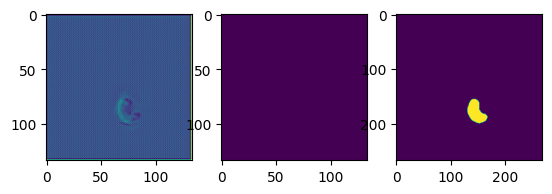

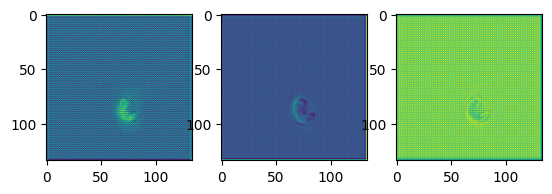

(32, 536, 536)


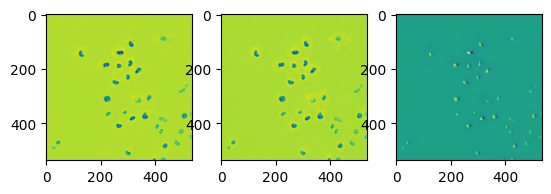

In [35]:
x = training_images[0][100:368,100:368]
x = torch.from_numpy(x).to('cuda:0')
x = x.unsqueeze(0)
x = x.unsqueeze(0)

unet = unet.to('cuda:0')
pred = unet(x).cpu().detach().numpy()[0]

def denormalize(array, min_value, max_value):
    normalized_range = 1.0
    normalized_array = array
    denormalized_array = (normalized_array * (max_value - min_value)) + min_value
    return denormalized_array

min_value = -17
max_value = 34
print(np.unique(pred))

#pred = denormalize(pred, min_value, max_value)

print(pred.shape[-1]>2)

print(pred.shape)
print(np.unique(pred))
#print(pred)

plt.subplot(1,3,1)
plt.imshow(pred[1])

detranspose = (1,2,0)
#p = pred.cpu().detach().numpy()
p = np.transpose(pred, detranspose)
p = utils.get_masks_unet(p, cell_threshold=0.0, boundary_threshold=0.0)
p = utils.fill_holes_and_remove_small_masks(p, min_size=15)

plt.subplot(1,3,2)
plt.imshow(p)

plt.subplot(1,3,3)
plt.imshow(training_cell_masks[0][100:368,100:368])

plt.show()

plt.subplot(1,3,1)
plt.imshow(pred[0])
plt.subplot(1,3,2)
plt.imshow(pred[1])
plt.subplot(1,3,3)
plt.imshow(pred[2])
plt.show()


y = training_pre_activations[0]
print(y.shape)
plt.subplot(1,3,1)
plt.imshow(y[0])
plt.subplot(1,3,2)
plt.imshow(y[1])
plt.subplot(1,3,3)
plt.imshow(y[2])
plt.show()

torch.Size([1, 32, 134, 134])
torch.Size([1, 32, 134, 134])


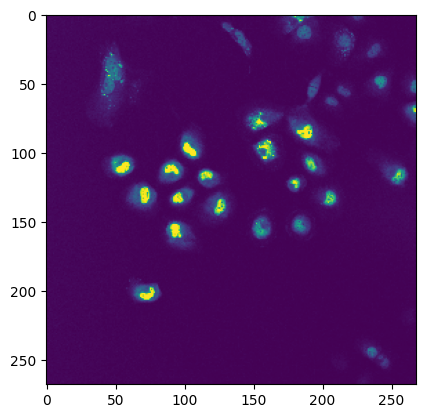

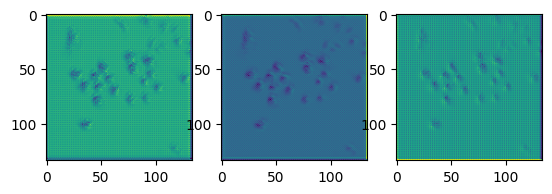

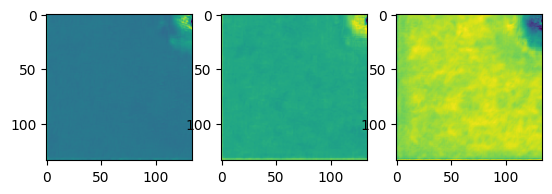

AttributeError: 'numpy.ndarray' object has no attribute 'softmax'

In [43]:
for image, cellprob, cellmask in train_loader:
    (image,cellprob,cellmask) = (image.to('cuda:0'),cellprob.to('cuda:0'),cellmask.to('cuda:0')) # sending the data to the device (cpu or GPU)

    image = image.unsqueeze(1)
    pred = unet(image).squeeze(1) #make a prediction

    print(pred.shape)
    print(cellprob.shape)

    plt.imshow(image.cpu().detach().numpy()[0][0])
    plt.show()

    y_pred = pred.cpu().detach().numpy()
    plt.subplot(1,3,1)
    plt.imshow(y_pred[0][0])
    plt.subplot(1,3,2)
    plt.imshow(y_pred[0][1])
    plt.subplot(1,3,3)
    plt.imshow(y_pred[0][2])
    plt.show()

    cellprob = cellprob.cpu().detach().numpy()
    plt.subplot(1,3,1)
    plt.imshow(cellprob[0][0])
    plt.subplot(1,3,2)
    plt.imshow(cellprob[0][1])
    plt.subplot(1,3,3)
    plt.imshow(cellprob[0][2])
    plt.show()

    

    y_pred = F.softmax(pred, dim=1)
    y_cp_true_softmax = F.softmax(cellprob, dim=1)
    kd_loss = F.cross_entropy(y_pred, y_cp_true_softmax)
    print(kd_loss)

    
    

    

    #print(pred.shape)

    break

In [ ]:
x = training_images[0][100:368,100:368]
x = torch.from_numpy(x).to('cuda:0')
x = x.unsqueeze(0)
x = x.unsqueeze(0)
unet = unet.to('cuda:0')
pred = unet(x)
y_pred_logits = pred 

y_pred = F.softmax(y_pred_logits, dim=1)
y_cp_true_softmax = F.softmax(y_cp_true, dim=1)
kd_loss = F.cross_entropy(y_pred, y_cp_true_softmax)

In [16]:
def denormalize(array, min_value, max_value):
    normalized_range = 1.0
    normalized_array = array
    denormalized_array = (normalized_array * (max_value - min_value)) + min_value
    return denormalized_array

# Example usage:
normalized_array = np.array([0, 0.13, 0.4, 0.677, 1])
min_value = -16
max_value = 32

# Denormalize the array
denormalized_array = denormalize(normalized_array, min_value, max_value)
print(denormalized_array)

[-16.     -9.76    3.2    16.496  32.   ]
